## Creating a House Price Estimating Model
* Collecting the data
* Cleaning the data
* 

In [187]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.tree import DecisionTreeRegressor
import pickle


In [9]:
# Loading the database
df = pd.read_csv('House_Data_BNG.csv',sep=',')
print(df.head(8))
print(df.shape)

              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   
5  Super built-up  Area  Ready To Move                Whitefield      2 BHK   
6  Super built-up  Area         18-May          Old Airport Road      4 BHK   
7  Super built-up  Area  Ready To Move              Rajaji Nagar      4 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  
5  Due

In [8]:
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [11]:
# Dropping unneccary columns
df2 = df.drop(['area_type','availability','society','balcony'],axis=1)
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [13]:
# Checking for the nullvalues
df2.isna().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [16]:
# dropping null value rows
df3 = df2.dropna()
df3.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [19]:
# Cleaning the dataset (For Encoding and stuff)
# Starting with BHK
len(df3['size'].unique())
#There are 31 unique values of size.

31

In [21]:
df3['bhk'] = df3['size'].apply(lambda data: int(data.split()[0]))
df3.head()

/tmp/ipykernel_6773/137720357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda data: int(data.split()[0]))


,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [37]:
# Now for total sqft
len(df3['total_sqft'].unique())
#there is 2067 unique values

2067

In [28]:
def check_float(data):
    try:
        float(x)
    except:
        return False
    return True

In [53]:
df3[~df3.total_sqft.apply(check_float)].loc[30]

location        Yelahanka
size                4 BHK
total_sqft    2100 - 2850
bath                  4.0
price               186.0
bhk                     4
Name: 30, dtype: object

In [49]:
def handle_range(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        output = (float(tokens[0])+float(tokens[1]))/2
        return output
    try:
        return float(x)
    except:
        return None

In [52]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(handle_range)
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [56]:
# Price per sqft
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.price_per_sqft.head()

0    3699.810606
1    4615.384615
2    4305.555556
3    6245.890861
4    4250.000000
Name: price_per_sqft, dtype: float64

In [64]:
# Now for location
df5.location =df5.location.apply(lambda data: data.strip())
len(df5.location.unique())
# There is 1293 unique loctions

1293

In [84]:
insights_location =df5.location.value_counts()
insights_location.values.sum()

13246

In [92]:
# Locations Having less than 10 datapoints ie : less than 10 houses in a location
location_less_than_10_houses =insights_location[insights_location <=10]
len(location_less_than_10_houses)

1052

In [97]:
# Since location_less_than_10_houses is more encoding all those will be tough , so we will change it to other
df5.location = df.location.apply(lambda data : 'other' if data in location_less_than_10_houses else data)
df5[df5.location == 'other']

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804
18,other,3 BHK,2770.0,4.0,290.00,3,10469.314079
19,other,2 BHK,1100.0,2.0,48.00,2,4363.636364
25,other,3 BHK,1250.0,3.0,56.00,3,4480.000000
42,other,1 BHK,600.0,1.0,38.00,1,6333.333333
...,...,...,...,...,...,...,...
13291,other,1 Bedroom,812.0,1.0,26.00,1,3201.970443
13292,other,3 BHK,1440.0,2.0,63.93,3,4439.583333
13302,other,2 BHK,1075.0,2.0,48.00,2,4465.116279
13306,other,4 Bedroom,1200.0,5.0,325.00,4,27083.333333


## Outlier Detection , ie Extreme Variation

In [109]:
# Normaly a 1BHK house will be atleast 300sqft , ie total_sqft/no_bedrooms > 300 
total_data_points = df5.shape[0]
total_data_points_not_following_the_area_rule = df5[(df5.total_sqft/df5.bhk)<300].shape[0]
total_correct_datapoint = total_data_points-total_data_points_not_following_the_area_rule
print(total_correct_datapoint)

12502


In [112]:
# In short
df6 = df5[~((df5.total_sqft/df5.bhk)<300)]
df6.shape

(12502, 7)

In [113]:
df6.groupby('location').sum()

,total_sqft,bath,price,bhk,price_per_sqft
location,,,,,
Anekal,351.00,1.0,16.000,1,4.558405e+03
Banaswadi,527.00,1.0,35.000,1,6.641366e+03
Basavangudi,670.00,1.0,50.000,1,7.462687e+03
Devarabeesana Halli,9238.00,16.0,749.000,16,4.740272e+04
Devarachikkanahalli,17731.00,31.0,878.000,34,6.957869e+04
...,...,...,...,...,...
Yelahanka New Town,46190.00,73.0,3404.500,81,2.227051e+05
Yelenahalli,16490.00,28.0,660.390,29,5.216316e+04
"Yemlur, Old Airport Road,",1595.00,3.0,115.000,3,7.210031e+03


In [118]:
def outliers_rm_price_sqft(data):
    data_to_return = pd.DataFrame()
    for key,subdata in data.groupby('location'):
        mean = np.mean(subdata.price_per_sqft)
        stdv = np.std(subdata.price_per_sqft)
        reduced_data = subdata[(subdata.price_per_sqft>(mean-stdv)) & (subdata.price_per_sqft<=(mean+stdv))]
        data_to_return = pd.concat([data_to_return,reduced_data], ignore_index=True)
    return data_to_return

In [121]:
df7 = outliers_rm_price_sqft(df6)
df7.isna().sum()
#now there is no null values

location          0
size              0
total_sqft        0
bath              0
price             0
bhk               0
price_per_sqft    0
dtype: int64

### more bhk means more money


In [146]:
def scatterplot(data,location):
    bhk_2 = data[(data.location == location) & (data.bhk == 2)]
    bhk_3 = data[(data.location == location) & (data.bhk == 3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk_2.total_sqft,bhk_2.price,color='red',label='2 BHK')
    plt.scatter(bhk_3.total_sqft,bhk_3.price,color='blue',label='3 BHK')

    plt.xlabel("Total Square Feet")
    plt.ylabel("Price")
    plt.title(location)
    plt.show()

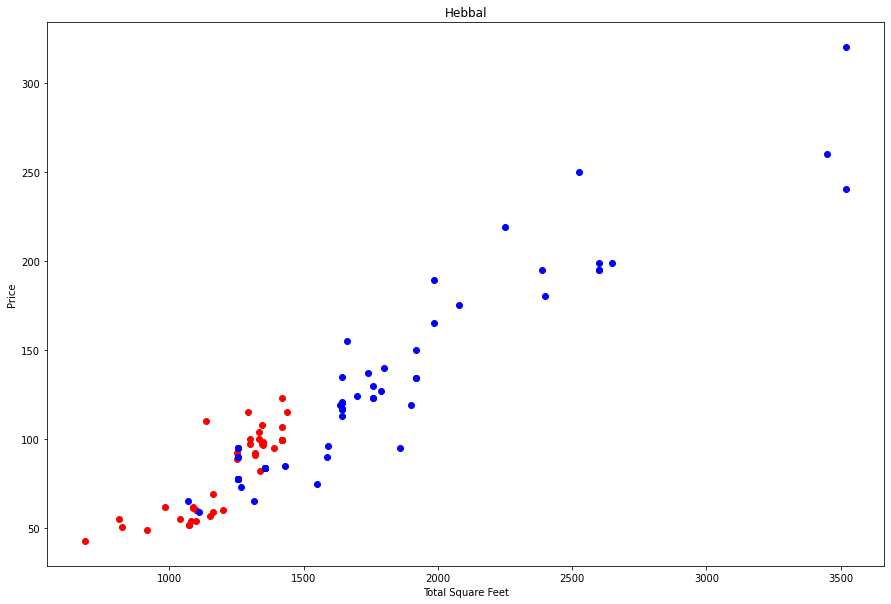

In [148]:
scatterplot(df7,"Hebbal")


In [150]:
def terminate_outliers_bhk(data):
    rem_indices = np.array([])
    for location,location_data in data.groupby('location'):
        bhk_stats = {}
        for bhk,bhk_data in location_data.groupby('bhk'):
            bhk_stats[bhk]= {
                'mean':np.mean(bhk_data.price_per_sqft),
                'std':np.std(bhk_data.price_per_sqft),
                'count':bhk_data.shape[0]
                }
        for bhk, bhk_data in location_data.groupby('bhk'):
            stat_bhk = bhk_stats.get(bhk-1)
            if stat_bhk and stat_bhk['count']>5:
90                rem_indices = np.append(rem_indices, bhk_data[bhk_data.price_per_sqft<(stat_bhk['mean'])].index.values)
    return data.drop(rem_indices,axis='index')
df8 = terminate_outliers_bhk(df7)
df8

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Devarabeesana Halli,3 BHK,1672.0,3.0,150.0,3,8971.291866
1,Devarabeesana Halli,3 BHK,1750.0,3.0,149.0,3,8514.285714
2,Devarabeesana Halli,3 BHK,1750.0,3.0,150.0,3,8571.428571
4,Devarachikkanahalli,2 BHK,1250.0,2.0,40.0,2,3200.000000
5,Devarachikkanahalli,2 Bedroom,1200.0,2.0,83.0,2,6916.666667
...,...,...,...,...,...,...,...
10192,other,2 BHK,1200.0,2.0,70.0,2,5833.333333
10193,other,1 BHK,1800.0,1.0,200.0,1,11111.111111
10196,other,2 BHK,1353.0,2.0,110.0,2,8130.081301
10197,other,1 Bedroom,812.0,1.0,26.0,1,3201.970443


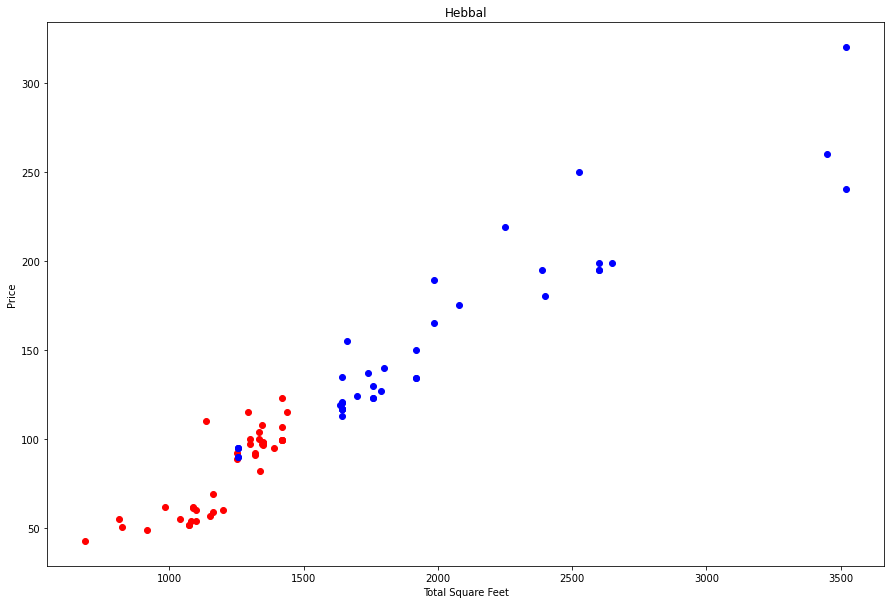

In [151]:
scatterplot(df8,"Hebbal")

In [153]:
# Now for no.of bathrooms
df8[df8.bath >10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5292,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8497,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8583,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9296,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9618,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


In [161]:
# removing the datapoint with bath > bhk+2
df9 = df8[~(df8.bath > df8.bhk+2)]
df9

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Devarabeesana Halli,3 BHK,1672.0,3.0,150.0,3,8971.291866
1,Devarabeesana Halli,3 BHK,1750.0,3.0,149.0,3,8514.285714
2,Devarabeesana Halli,3 BHK,1750.0,3.0,150.0,3,8571.428571
4,Devarachikkanahalli,2 BHK,1250.0,2.0,40.0,2,3200.000000
5,Devarachikkanahalli,2 Bedroom,1200.0,2.0,83.0,2,6916.666667
...,...,...,...,...,...,...,...
10192,other,2 BHK,1200.0,2.0,70.0,2,5833.333333
10193,other,1 BHK,1800.0,1.0,200.0,1,11111.111111
10196,other,2 BHK,1353.0,2.0,110.0,2,8130.081301
10197,other,1 Bedroom,812.0,1.0,26.0,1,3201.970443


In [168]:
# Encoding and dropping
df10 = df9.drop(['size','price_per_sqft'],axis=1)

In [169]:
dummy_set = pd.get_dummies(df10.location)
df10 = pd.concat([df10,dummy_set],axis=1)

In [172]:
df11 = df10.drop(['location','other'], axis=1)
df11

,total_sqft,bath,price,bhk,Devarabeesana Halli,Devarachikkanahalli,Electronic City,Mysore Highway,Rachenahalli,Thanisandra,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,"Whitefield,",Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1672.0,3.0,150.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1750.0,3.0,149.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1750.0,3.0,150.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1250.0,2.0,40.0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1200.0,2.0,83.0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10192,1200.0,2.0,70.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10193,1800.0,1.0,200.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10196,1353.0,2.0,110.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10197,812.0,1.0,26.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [207]:
X = df11.drop(['price'],axis=1)
y = df11.price
X.to_csv("./X.csv",index=False,sep=',')

## Simple Linear Regression

In [224]:
# Laura =LinearRegression()
# best_score  = -1
# for _ in range(100):
#     x_train,x_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.2)
#     Laura.fit(x_train,y_train)
#     acc = Laura.score(x_test,y_test)
#     if acc > best_score:
#         best_score = acc
#         with open("Laura_Linear_model.pickle","wb") as f:
#             pickle.dump(Laura,f)
# print(best_score)

0.8997742735773754


In [245]:
Laura = LinearRegression()
acc = -1
while(acc<=.91):
    x_train,x_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.1)
    Laura.fit(x_train,y_train)
    acc = Laura.score(x_test,y_test)
    print(acc)
with open("Laura_Linear_model3.pickle","wb") as f:
    pickle.dump(Laura,f)

-7641078459685097.0
0.8617150974911867
0.8748794299980787
0.8407506222576455
0.8365825185221601
0.8241397520849059
0.8756885947603807
0.7714865257373394
0.7607529976512826
-258617922887600.25
0.907341619155505
0.8716320694550221
-4369564401633042.0
0.743346237807318
-1.1415719129050168e+16
-360703972123559.7
-789691109073865.6
-1873886267651461.2
-155673689318851.53
0.8709609589582794
0.8566010988096536
0.869503686297843
0.773552916613344
0.8183024144473287
-7.426379365093712e+16
-5.105416612610706e+17
0.7557774977903974
0.829877720787161
0.7889010301110246
0.8072920482734579
-21883850611.24778
0.8777685641859423
0.8513347614277378
-1992116410155758.2
-494164230280474.4
0.8593438625511345
0.8624036269228477
0.8422301270965864
0.8567783379780262
0.7853698694775989
0.8424789439288713
0.8372038675634588
0.7774634014823679
0.8548799986720275
0.8458034135104471
0.8487160762841722
0.820859919427156
0.8467273778810164
0.8248277890785064
0.8659189888918324
-266410746164031.94
0.865608214066378

## GridSearchCV

In [201]:
def grid_search_cv(X,y):
    algos = {
        'LinearRegression' : {
            'model': LinearRegression(),
            'params': {
                'normalize' : [True,False],
                'positive' : [True,False]
                }
            },
        'Lasso' : {
            'model': Lasso(),
            'params':{
                'alpha' : [1,2],
                'selection' : ['random','cyclic']
                } 
            },
        'DecisionTree':{
            'model' : DecisionTreeRegressor(),
            'params':{
                'criterion' : ['mse','friedman_mse'],
                'splitter' :['best','random']
                }
            }
        }
    scores = []
    cv = model_selection.ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    for algo_name,config in algos.items():
        gs = model_selection.GridSearchCV(config['model'],config['params'],cv=cv,return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model':algo_name,
            'best_score':gs.best_score_,
            'best_params':gs.best_params_
        })
    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [202]:
grid_search_cv(X,y)

,model,best_score,best_params
0,LinearRegression,0.812700,"{'normalize': False, 'positive': True}"
1,Lasso,0.691579,"{'alpha': 1, 'selection': 'cyclic'}"
2,DecisionTree,0.750706,"{'criterion': 'mse', 'splitter': 'best'}"


## Predict Function

In [271]:
def predict_price(location,sqft,bath,bhk):
    pickle_in = open("Laura_Linear_model3.pickle","rb")
    Laura = pickle.load(pickle_in)
    loc_index = np.where(X.columns==location)[0][0]
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index>=0:
        x[loc_index] = 1
        
    return Laura.predict([x])[0]

In [272]:
predict_price('Devarachikkanahalli',1250,2,2)

59.722121522740935